In [16]:
# Cell 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('/kaggle/input/sensor1data/Copy of ESP32 Data - Snsor 1.csv')
print("Original Data Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())


Original Data Shape: (650, 7)

First few rows:
            Timestamp  MAX6675_TEMP_C  Custom_ADC  Custom_Vout  \
0  10/3/2025 22:20:17           23.50        2919        2.352   
1  10/3/2025 22:20:29           23.75        2919        2.352   
2  10/3/2025 22:20:41           23.50        2921        2.354   
3  10/3/2025 22:20:52           23.50        2901        2.338   
4  10/3/2025 22:21:04           23.00        2923        2.356   

   Custom_Resistance  Env_Temp_C  Env_Humidity_%  
0            4028.78       26.02           54.34  
1            4028.78       25.68           54.94  
2            4019.17       25.37           56.44  
3            4115.82       25.09           56.47  
4            4009.58       24.84           56.71  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          650 non-null  

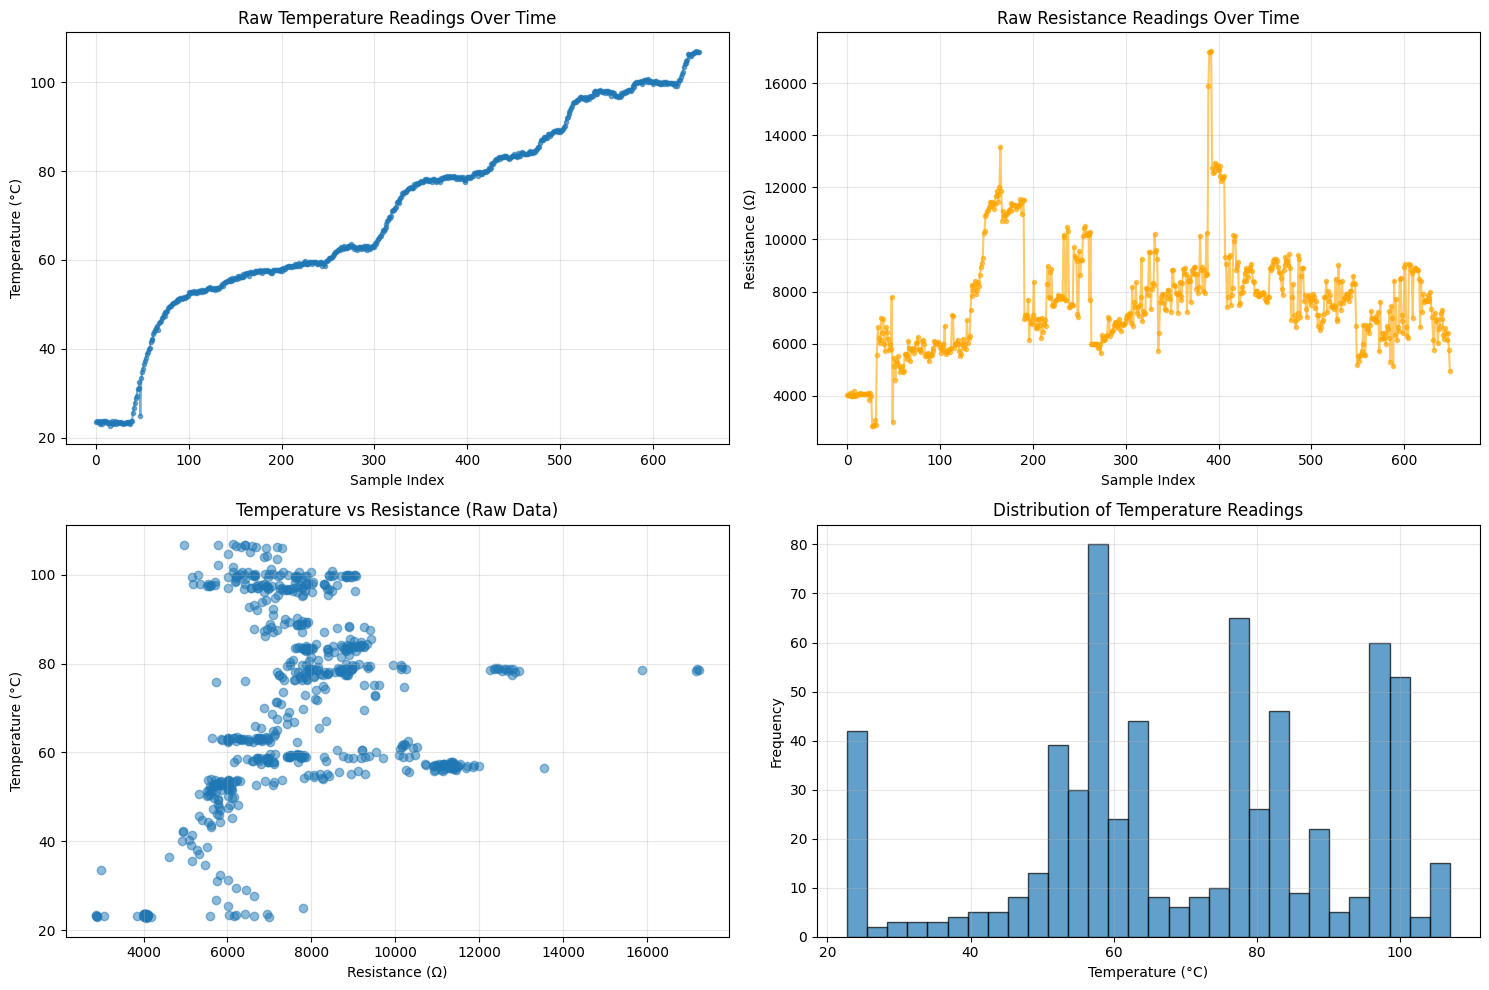

In [17]:
# Cell 2: Initial Data Exploration and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Temperature over time
axes[0, 0].plot(df.index, df['MAX6675_TEMP_C'], 'o-', markersize=3, alpha=0.6)
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_title('Raw Temperature Readings Over Time')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Resistance over time
axes[0, 1].plot(df.index, df['Custom_Resistance'], 'o-', markersize=3, alpha=0.6, color='orange')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Resistance (Ω)')
axes[0, 1].set_title('Raw Resistance Readings Over Time')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Temperature vs Resistance (raw)
axes[1, 0].scatter(df['Custom_Resistance'], df['MAX6675_TEMP_C'], alpha=0.5)
axes[1, 0].set_xlabel('Resistance (Ω)')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].set_title('Temperature vs Resistance (Raw Data)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Distribution of temperature readings
axes[1, 1].hist(df['MAX6675_TEMP_C'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Temperature (°C)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Temperature Readings')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('raw_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
def remove_temperature_jumps(df, temp_col='MAX6675_TEMP_C', threshold=5.0):
    """
    Remove sudden temperature jumps that are physically unrealistic.
    A temperature change > threshold between consecutive readings is flagged.
    """
    df_clean = df.copy()
    temp_diff = df_clean[temp_col].diff().abs()
    
    # Flag large jumps
    large_jumps = temp_diff > threshold
    
    print(f"Identified {large_jumps.sum()} large temperature jumps (>{threshold}°C)")
    
    # Create a mask for valid data points
    # Keep first point, then only keep points without large jumps
    valid_mask = ~large_jumps
    valid_mask.iloc[0] = True  # Always keep first point
    
    return df_clean[valid_mask].reset_index(drop=True), large_jumps

df_clean, jump_mask = remove_temperature_jumps(df, threshold=5.0)
print(f"\nData shape after removing temperature jumps: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows")


Identified 2 large temperature jumps (>5.0°C)

Data shape after removing temperature jumps: (648, 7)
Removed 2 rows


In [19]:
def remove_statistical_outliers(df, columns, method='iqr', z_threshold=3):
    """
    Remove outliers using IQR or Z-score method.
    """
    df_clean = df.copy()
    
    for col in columns:
        if method == 'iqr':
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            mask = (df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)
            outliers = (~mask).sum()
            
        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(df_clean[col]))
            mask = z_scores < z_threshold
            outliers = (~mask).sum()
        
        print(f"{col}: Removed {outliers} outliers using {method} method")
        df_clean = df_clean[mask]
    
    return df_clean.reset_index(drop=True)

# Remove outliers from key columns
cols_to_check = ['MAX6675_TEMP_C', 'Custom_Resistance']
df_clean = remove_statistical_outliers(df_clean, cols_to_check, method='iqr')
print(f"\nData shape after outlier removal: {df_clean.shape}")


MAX6675_TEMP_C: Removed 0 outliers using iqr method
Custom_Resistance: Removed 17 outliers using iqr method

Data shape after outlier removal: (631, 7)


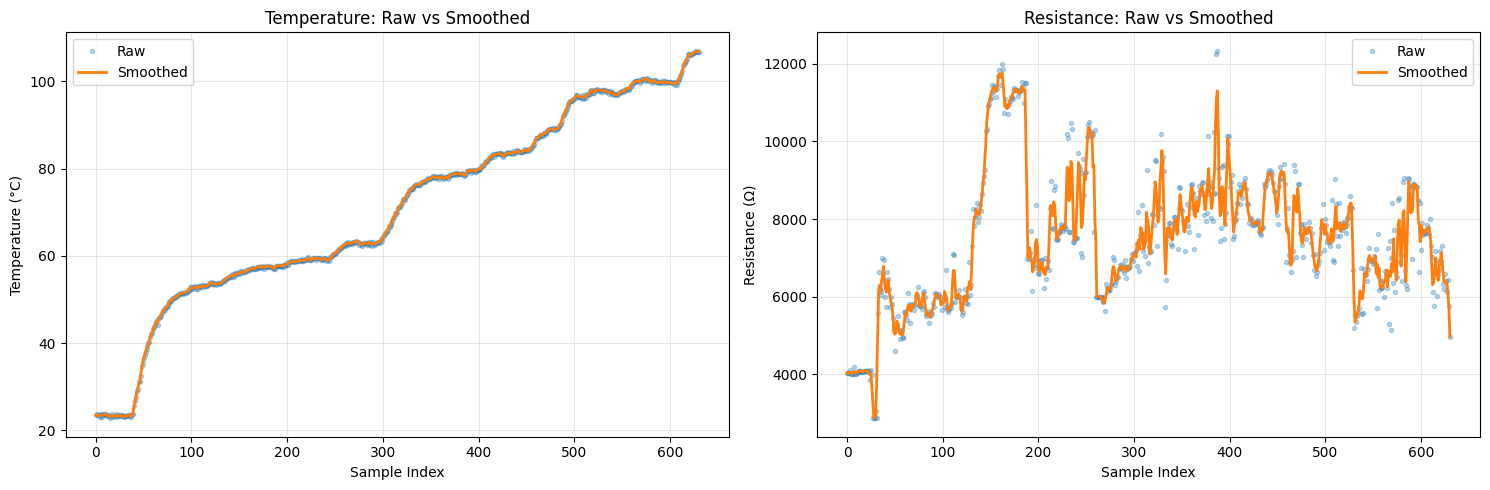

In [20]:
# Cell 5: Data Cleaning - Step 3: Smooth Noisy Data
def apply_moving_average(df, columns, window=3):
    """
    Apply moving average to smooth noisy sensor data.
    """
    df_smooth = df.copy()
    
    for col in columns:
        df_smooth[f'{col}_smooth'] = df_smooth[col].rolling(window=window, center=True).mean()
        # Fill NaN values at edges
        df_smooth[f'{col}_smooth'].fillna(df_smooth[col], inplace=True)
    
    return df_smooth

# Apply smoothing
df_clean = apply_moving_average(df_clean, ['MAX6675_TEMP_C', 'Custom_Resistance'], window=3)

# Visualize smoothing effect
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(df_clean.index, df_clean['MAX6675_TEMP_C'], 'o', alpha=0.3, label='Raw', markersize=3)
axes[0].plot(df_clean.index, df_clean['MAX6675_TEMP_C_smooth'], '-', linewidth=2, label='Smoothed')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Temperature: Raw vs Smoothed')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_clean.index, df_clean['Custom_Resistance'], 'o', alpha=0.3, label='Raw', markersize=3)
axes[1].plot(df_clean.index, df_clean['Custom_Resistance_smooth'], '-', linewidth=2, label='Smoothed')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Resistance (Ω)')
axes[1].set_title('Resistance: Raw vs Smoothed')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('smoothing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Cell 6: Feature Engineering
# Create additional features that might help the model
df_clean['R_squared'] = df_clean['Custom_Resistance_smooth'] ** 2
df_clean['R_inverse'] = 1 / df_clean['Custom_Resistance_smooth']
df_clean['R_log'] = np.log(df_clean['Custom_Resistance_smooth'])
df_clean['Temp_env_humidity'] = df_clean['Env_Temp_C'] * df_clean['Env_Humidity_%']

print("Feature Engineering Complete")
print("\nNew features created:")
print("- R_squared: Resistance squared")
print("- R_inverse: 1/Resistance (for non-linear relationships)")
print("- R_log: Log of Resistance")
print("- Temp_env_humidity: Interaction term")

Feature Engineering Complete

New features created:
- R_squared: Resistance squared
- R_inverse: 1/Resistance (for non-linear relationships)
- R_log: Log of Resistance
- Temp_env_humidity: Interaction term


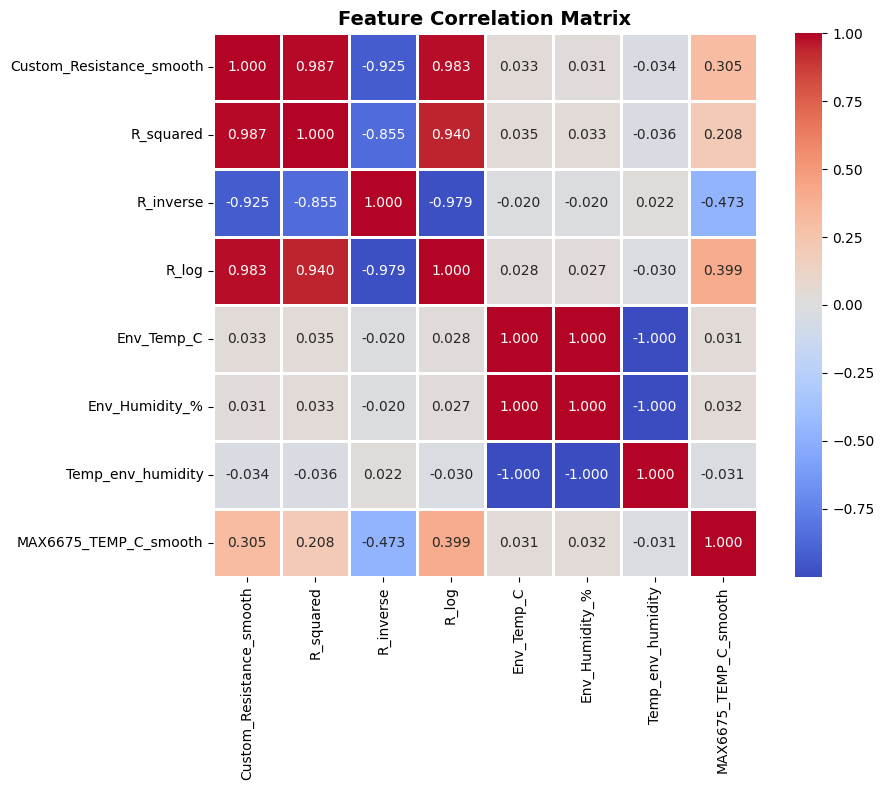


Correlation with Temperature (sorted):
MAX6675_TEMP_C_smooth       1.000000
R_log                       0.399496
Custom_Resistance_smooth    0.304816
R_squared                   0.208312
Env_Humidity_%              0.031733
Env_Temp_C                  0.031346
Temp_env_humidity          -0.031102
R_inverse                  -0.473430
Name: MAX6675_TEMP_C_smooth, dtype: float64


In [22]:
# Cell 7: Correlation Analysis
# Analyze correlations between features and target
correlation_features = [
    'Custom_Resistance_smooth', 'R_squared', 'R_inverse', 'R_log',
    'Env_Temp_C', 'Env_Humidity_%', 'Temp_env_humidity'
]

correlation_matrix = df_clean[correlation_features + ['MAX6675_TEMP_C_smooth']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.3f')
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top correlations with temperature
temp_correlations = correlation_matrix['MAX6675_TEMP_C_smooth'].sort_values(ascending=False)
print("\nCorrelation with Temperature (sorted):")
print(temp_correlations)


In [23]:
# Cell 8: Prepare Data for Machine Learning
# Define features and target
X_columns = ['Custom_Resistance_smooth', 'R_inverse', 'R_log', 
             'Env_Temp_C', 'Env_Humidity_%']
y_column = 'MAX6675_TEMP_C_smooth'

X = df_clean[X_columns].values
y = df_clean[y_column].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nFeatures used: {X_columns}")

Training set size: 504
Test set size: 127

Features used: ['Custom_Resistance_smooth', 'R_inverse', 'R_log', 'Env_Temp_C', 'Env_Humidity_%']


In [24]:
# Cell 9: Model 1 - Linear Regression
print("="*60)
print("MODEL 1: LINEAR REGRESSION")
print("="*60)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_train_lr = lr_model.predict(X_train_scaled)
y_pred_test_lr = lr_model.predict(X_test_scaled)

# Metrics
print("\nTraining Performance:")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_lr):.4f} °C")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_lr)):.4f} °C")
print(f"R²: {r2_score(y_train, y_pred_train_lr):.4f}")

print("\nTest Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_lr):.4f} °C")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_lr)):.4f} °C")
print(f"R²: {r2_score(y_test, y_pred_test_lr):.4f}")

# Print model equation
print("\n" + "="*60)
print("LINEAR REGRESSION EQUATION (scaled features):")
print("="*60)
print(f"T = {lr_model.intercept_:.4f}")
for i, feature in enumerate(X_columns):
    print(f"    + ({lr_model.coef_[i]:+.6f}) * {feature}_scaled")

MODEL 1: LINEAR REGRESSION

Training Performance:
MAE: 13.0460 °C
RMSE: 16.7821 °C
R²: 0.4335

Test Performance:
MAE: 12.8069 °C
RMSE: 16.2720 °C
R²: 0.3966

LINEAR REGRESSION EQUATION (scaled features):
T = 71.0352
    + (-149.892479) * Custom_Resistance_smooth_scaled
    + (+83.411351) * R_inverse_scaled
    + (+238.191069) * R_log_scaled
    + (+64.362466) * Env_Temp_C_scaled
    + (-63.617344) * Env_Humidity_%_scaled


In [25]:
# Cell 10: Model 2 - Random Forest Regressor
print("\n" + "="*60)
print("MODEL 2: RANDOM FOREST REGRESSOR")
print("="*60)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

y_pred_train_rf = rf_model.predict(X_train_scaled)
y_pred_test_rf = rf_model.predict(X_test_scaled)

# Metrics
print("\nTraining Performance:")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_rf):.4f} °C")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_rf)):.4f} °C")
print(f"R²: {r2_score(y_train, y_pred_train_rf):.4f}")

print("\nTest Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_rf):.4f} °C")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_rf)):.4f} °C")
print(f"R²: {r2_score(y_test, y_pred_test_rf):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


MODEL 2: RANDOM FOREST REGRESSOR

Training Performance:
MAE: 2.4672 °C
RMSE: 4.5749 °C
R²: 0.9579

Test Performance:
MAE: 5.0775 °C
RMSE: 7.8783 °C
R²: 0.8585

Feature Importance:
                    Feature  Importance
3                Env_Temp_C    0.365681
1                 R_inverse    0.215182
2                     R_log    0.153261
0  Custom_Resistance_smooth    0.145939
4            Env_Humidity_%    0.119937


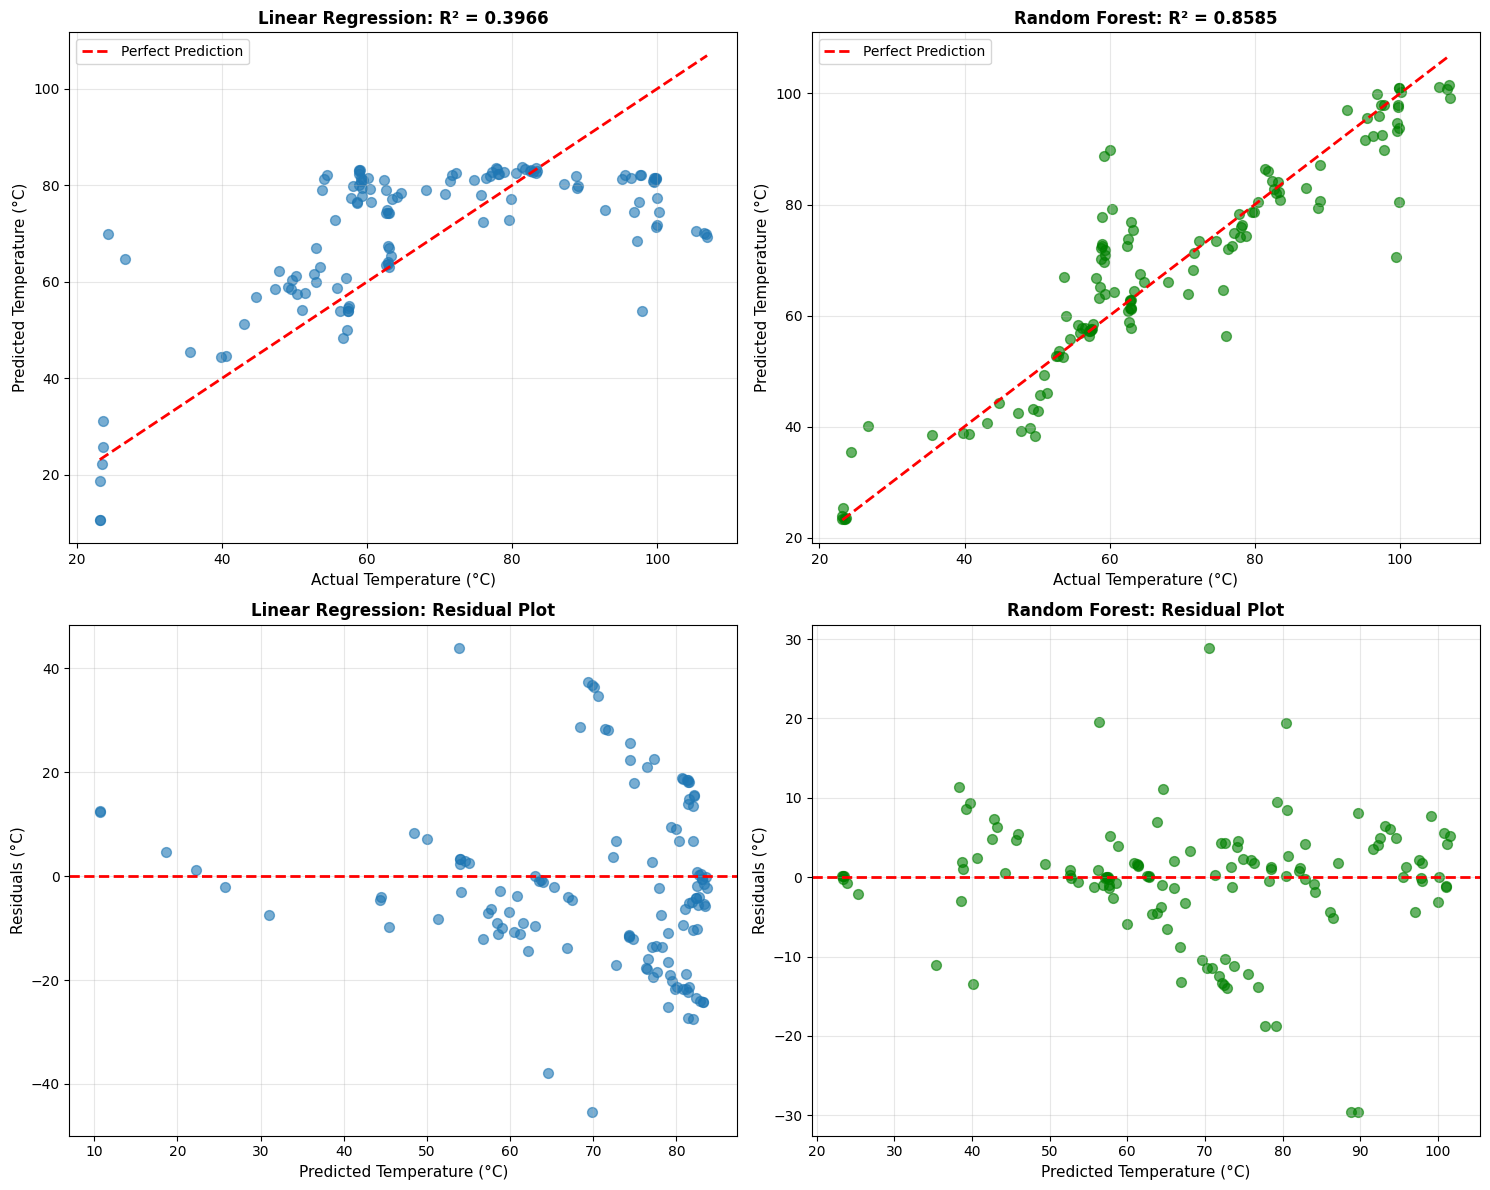

In [26]:
# Cell 11: Visualize Model Performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Linear Regression - Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred_test_lr, alpha=0.6, s=50)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Temperature (°C)', fontsize=11)
axes[0, 0].set_ylabel('Predicted Temperature (°C)', fontsize=11)
axes[0, 0].set_title(f'Linear Regression: R² = {r2_score(y_test, y_pred_test_lr):.4f}', 
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Random Forest - Predicted vs Actual
axes[0, 1].scatter(y_test, y_pred_test_rf, alpha=0.6, s=50, color='green')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Temperature (°C)', fontsize=11)
axes[0, 1].set_ylabel('Predicted Temperature (°C)', fontsize=11)
axes[0, 1].set_title(f'Random Forest: R² = {r2_score(y_test, y_pred_test_rf):.4f}', 
                     fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals - Linear Regression
residuals_lr = y_test - y_pred_test_lr
axes[1, 0].scatter(y_pred_test_lr, residuals_lr, alpha=0.6, s=50)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Temperature (°C)', fontsize=11)
axes[1, 0].set_ylabel('Residuals (°C)', fontsize=11)
axes[1, 0].set_title('Linear Regression: Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals - Random Forest
residuals_rf = y_test - y_pred_test_rf
axes[1, 1].scatter(y_pred_test_rf, residuals_rf, alpha=0.6, s=50, color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted Temperature (°C)', fontsize=11)
axes[1, 1].set_ylabel('Residuals (°C)', fontsize=11)
axes[1, 1].set_title('Random Forest: Residual Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()


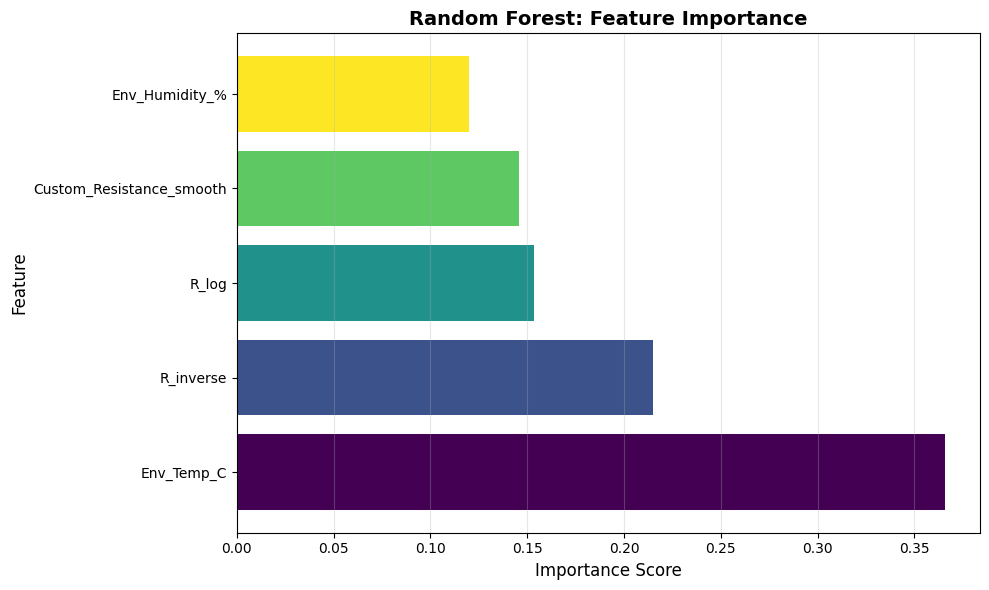

In [27]:
# Cell 12: Feature Importance Visualization
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest: Feature Importance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# Cell 13: Create Prediction Function
def predict_temperature(R, T_env, H, model='rf', return_confidence=False):
    """
    Predict temperature from resistance, environmental temperature, and humidity.
    
    Parameters:
    -----------
    R : float
        Resistance value (Ohms)
    T_env : float
        Environmental temperature (°C)
    H : float
        Humidity (%)
    model : str
        'lr' for Linear Regression, 'rf' for Random Forest
    return_confidence : bool
        If True, return prediction interval (only for RF)
    
    Returns:
    --------
    float or tuple
        Predicted temperature (°C), optionally with confidence interval
    """
    # Create features
    R_inverse = 1 / R
    R_log = np.log(R)
    
    # Prepare input
    X_input = np.array([[R, R_inverse, R_log, T_env, H]])
    X_input_scaled = scaler.transform(X_input)
    
    # Predict
    if model == 'lr':
        T_pred = lr_model.predict(X_input_scaled)[0]
        if return_confidence:
            print("Confidence intervals only available for Random Forest")
        return T_pred
    
    elif model == 'rf':
        T_pred = rf_model.predict(X_input_scaled)[0]
        
        if return_confidence:
            # Get predictions from all trees
            predictions = np.array([tree.predict(X_input_scaled)[0] 
                                  for tree in rf_model.estimators_])
            confidence_interval = (np.percentile(predictions, 5), 
                                 np.percentile(predictions, 95))
            return T_pred, confidence_interval
        return T_pred

# Test the function
test_R = 5533
test_T_env = 22
test_H = 63

print("="*60)
print("TEMPERATURE PREDICTION FUNCTION TEST")
print("="*60)
print(f"\nInput:")
print(f"  Resistance: {test_R} Ω")
print(f"  Env Temperature: {test_T_env} °C")
print(f"  Humidity: {test_H} %")

print(f"\nPredictions:")
T_lr = predict_temperature(test_R, test_T_env, test_H, model='lr')
print(f"  Linear Regression: {T_lr:.2f} °C")

T_rf, conf_int = predict_temperature(test_R, test_T_env, test_H, 
                                    model='rf', return_confidence=True)
print(f"  Random Forest: {T_rf:.2f} °C")
print(f"  90% Confidence Interval: [{conf_int[0]:.2f}, {conf_int[1]:.2f}] °C")

TEMPERATURE PREDICTION FUNCTION TEST

Input:
  Resistance: 5533 Ω
  Env Temperature: 22 °C
  Humidity: 63 %

Predictions:
  Linear Regression: 53.74 °C
  Random Forest: 42.17 °C
  90% Confidence Interval: [33.53, 50.64] °C
